
# Compressive Sensing

This example demonstrates following features
- Adquisition step: Compressive measurements of a sparse signal 
- Recovering step: Recovering the original signal using the IHT (Iterative Hard Thresholding) algorithm.


Let's import necessary libraries 
*   [jax](https://github.com/google/jax): library for high-performance machine learning and numerical computations.
*   [cr-sparse](https://github.com/carnotresearch/cr-sparse): library for sparse signal represesentation with JAX.
* [cr-nimble](https://github.com/carnotresearch/cr-nimble): library for iterative algorithms for numerical linear algebra with JAX.

In [1]:
import jax
from jax import random
import jax.numpy as jnp  # Accelerated numpy library.
from jax.numpy.linalg import norm

import matplotlib as mpl
import matplotlib.pyplot as plt

import cr.nimble as cnb
import cr.sparse as crs
import cr.sparse.dict as crdict
import cr.sparse.data as crdata
import cr.sparse.cs.cs1bit as cs1bit
from cr.sparse import lop

import time

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Setup



In [2]:
# Number of measurements
M = 200
# Ambient dimension
N = 500
# Sparsity level
K = 50

# Sensing Matrix
_Function help_
- [gaussian_mtx()](https://cr-sparse.readthedocs.io/en/latest/source/_autosummary/cr.sparse.dict.gaussian_mtx.html?highlight=gaussian_mtx)


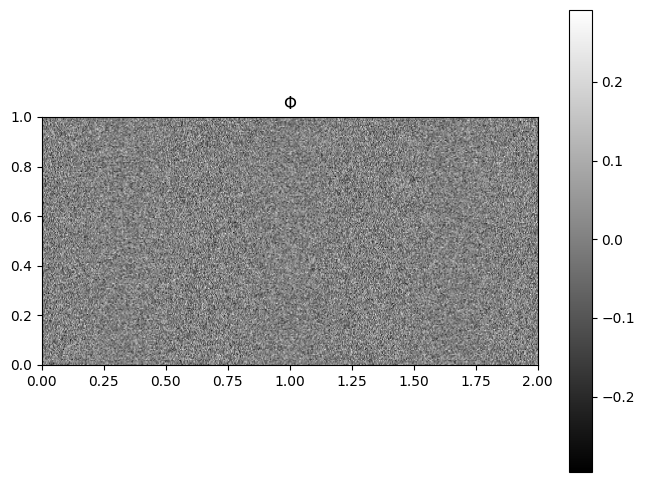

In [3]:
# Sensing matrix
Phi = crdict.gaussian_mtx(cnb.KEYS[0], M, N, normalize_atoms=True) 

# Frame bound (You can ignore this)
s0 = crdict.upper_frame_bound(Phi)  # Computes the upper frame bound for a dictionary. Upper frame bound: https://en.wikipedia.org/wiki/Frame_(linear_algebra)

# Plot sensing matrix
fig = plt.figure(figsize=(8, 6), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(Phi, extent=[0, 2, 0, 1])
plt.gray()
plt.colorbar()
plt.title(r'$\Phi$');

# A compressible vector

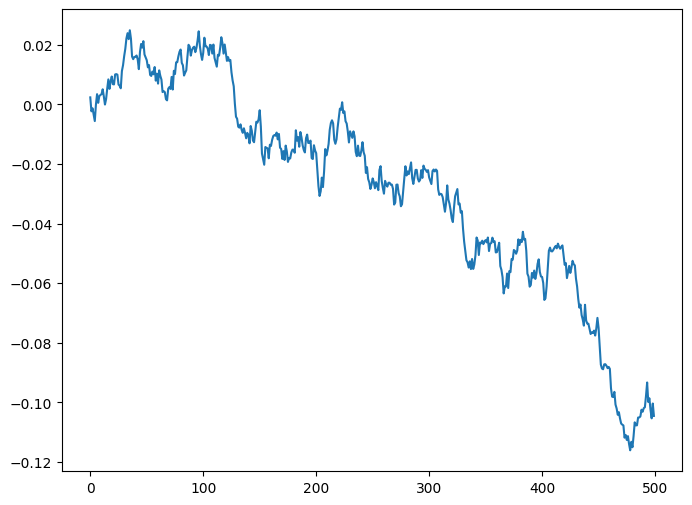

In [4]:
# Signal
x = 100 * jnp.cumsum(random.normal(cnb.KEYS[1], (N,)))

# Normalize signal
x = x / norm(x)
plt.figure(figsize=(8, 6), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(x);

## The Sparsifying Basis

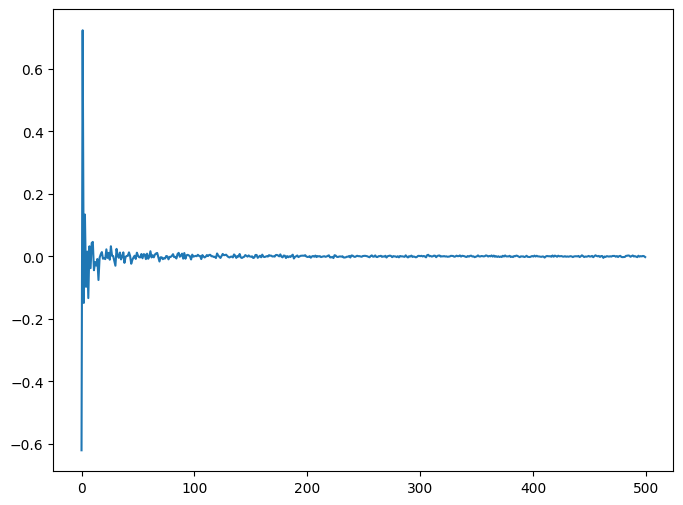

In [5]:
# Sparsifying basis
Psi  = lop.jit(lop.cosine_basis(N))

# Direct transformation
a = Psi.trans(x)

# Plot transformation
plt.figure(figsize=(8, 6), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(a);

# Measurement process or acquisition step
Compressive measurements

Elapse time:1.4336e-02 seconds


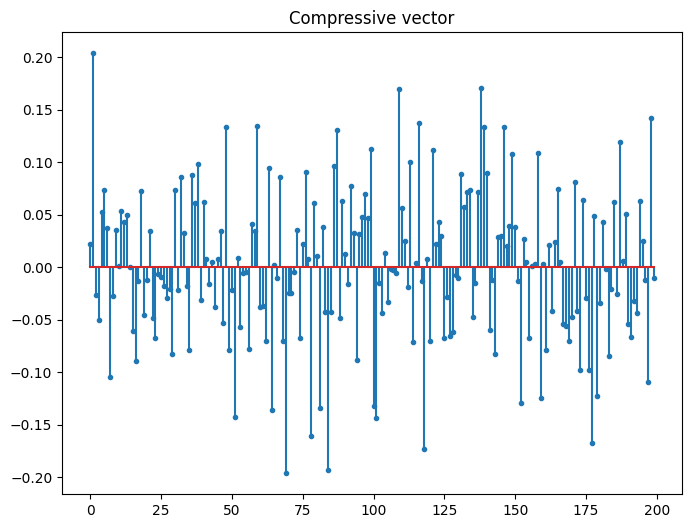

In [6]:
# Matrix multiplication
start = time.time()
y = Phi @ a
end = time.time()
print(f'Elapse time:{end - start:.4e} seconds')

# Plot compressive vector with and without noise
fig = plt.figure(figsize=(8, 6), dpi= 100, facecolor='w', edgecolor='k')
plt.stem(y, markerfmt='.');
plt.title('Compressive vector');

# Signal Reconstruction/Recovering using IHT (Iterative Hard Thresholding)

### IHT (Iterative Hard Thresholding)
- See [Greedy Sparse Recovery](https://carnotresearch.github.io/cr-sparse/source/pursuit.html)

In [7]:
from cr.sparse.pursuit import iht
sol = iht.matrix_solve_jit(Phi, y, K, normalized=True, step_size=None, max_iters=None, res_norm_rtol=0.0001)
a_rec = cnb.dsp.build_signal_from_indices_and_values(N, sol.I, sol.x_I)
x_rec = Psi.times(a_rec)

I = [  0   1   2   3   4   6   7   8   9  10  11  13  15  18  19  22  26  30
  31  37  38  39  44  54  58  61  69  89 105 122 127 153 166 178 215 217
 232 265 274 329 336 358 365 375 406 424 441 449 457 490]


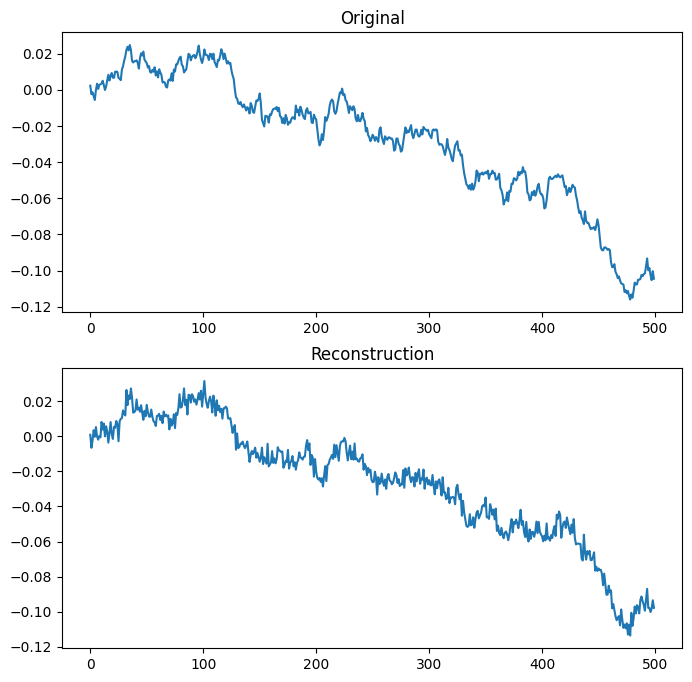

In [8]:
# Plot original and reconstructed signals
fig = plt.figure(figsize=(8, 8), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(211)
plt.title('Original')
plt.plot(x);
plt.subplot(212)
plt.plot(x_rec);
plt.title('Reconstruction')

# recovered support
I = jnp.sort(sol.I)
print(f"I = {I}")

#### Verification

In [9]:
# The norm of error
print(f'Error: {norm(x - x_rec):.4e}')

Error: 1.1512e-01
